In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Rectangle

In [7]:
cfg_path = "yolov3-tiny.cfg"
weights_path = "yolov3-tiny.weights"

def load_yolo():
    cfg_path = "yolov3-tiny.cfg"
    weights_path = "yolov3-tiny.weights"
    net = cv2.dnn.readNet(weights_path, cfg_path)
    layer_names = net.getLayerNames()
    layer_indexes = net.getUnconnectedOutLayers()

    # Проверяем, возвращает ли getUnconnectedOutLayers одномерный массив
    if layer_indexes.ndim == 1:
        output_layers = [layer_names[index - 1] for index in layer_indexes]
    else:
        output_layers = [layer_names[index[0] - 1] for index in layer_indexes]

    return net, output_layers

def detect_objects(img, net, outputLayers):            
    blob = cv2.dnn.blobFromImage(img, scalefactor=0.00392, size=(416, 416), mean=(0, 0, 0), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(outputLayers)
    return blob, outputs

In [14]:
def get_box_dimensions(outputs, height, width):
    boxes = []
    confs = []
    class_ids = []
    for output in outputs:
        for detect in output:
            scores = detect[5:]
            class_id = np.argmax(scores)
            conf = scores[class_id]
            if class_id == 0 and conf > 0.3:  # Assuming class 0 is 'person'
                center_x = int(detect[0] * width)
                center_y = int(detect[1] * height)
                w = int(detect[2] * width)
                h = int(detect[3] * height)
                x = center_x - w // 2
                y = center_y - h // 2
                boxes.append([x, y, w, h])
                confs.append(float(conf))
                class_ids.append(class_id)
    return boxes, confs, class_ids


def draw_labels(boxes, confs, colors, class_ids, img):
    plt.figure(figsize=(12, 8))
    # Переводим изображение из BGR в RGB для отображения с помощью matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    ax = plt.gca()

    for i, box in enumerate(boxes):
        x, y, w, h = box
        # Нормализация цвета для matplotlib
        normalized_color = [color / 255.0 for color in colors[i]]
        rect = Rectangle((x, y), w, h, linewidth=2, edgecolor=normalized_color, facecolor='none')
        ax.add_patch(rect)
        plt.text(x, y, str(class_ids[i]), color=normalized_color, fontsize=12, verticalalignment='top')
    
    plt.axis('off')  # Отключаем отображение осей
    plt.show()  # Отображаем изображение

def process_images_from_folder(folder_path):
    net, output_layers = load_yolo()
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            img = cv2.imread(image_path)
            if img is None:
                print(f"Failed to load image: {image_path}")
                continue
            height, width, _ = img.shape
            blob, outputs = detect_objects(img, net, output_layers)
            boxes, confs, class_ids = get_box_dimensions(outputs, height, width)
            colors = np.random.uniform(0, 255, size=(len(boxes), 3))
            draw_labels(boxes, confs, colors, class_ids, img)


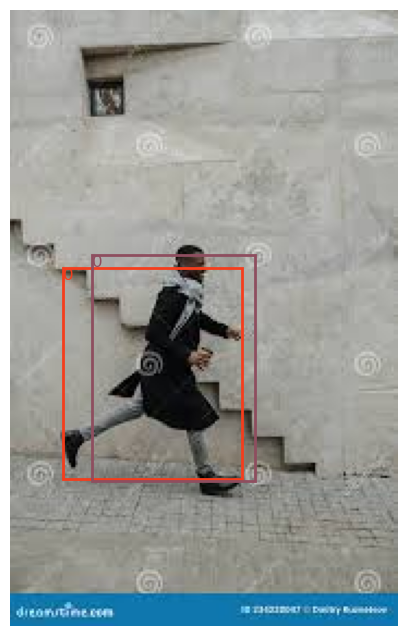

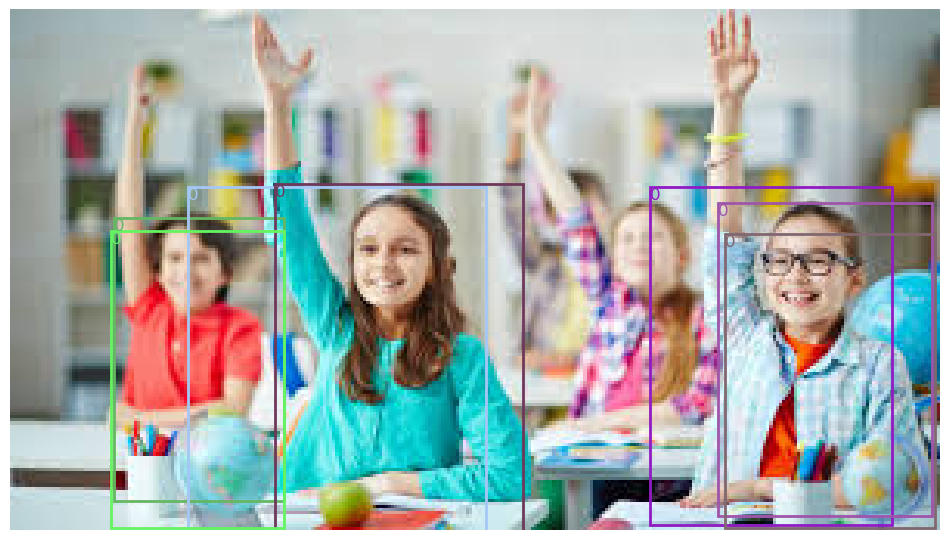

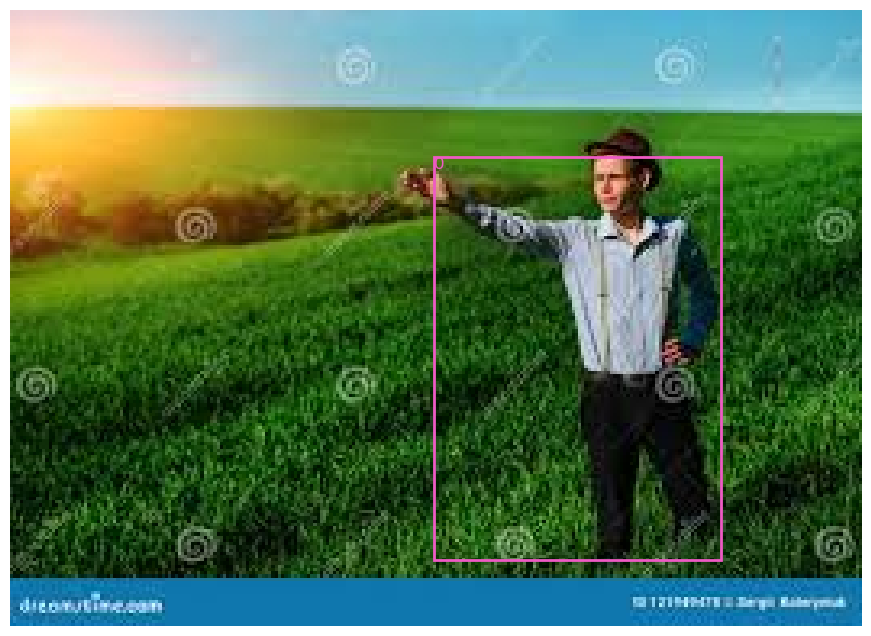

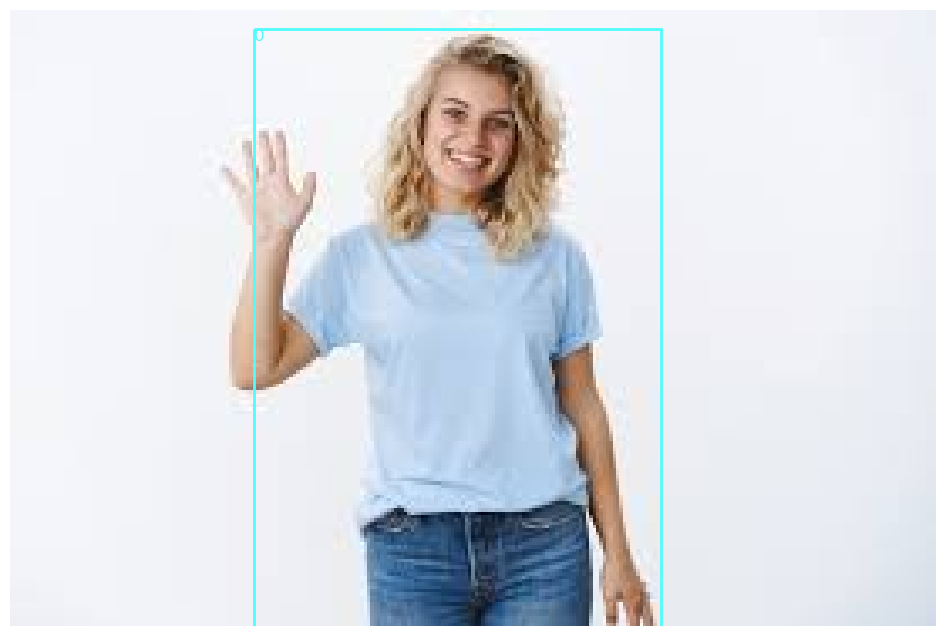

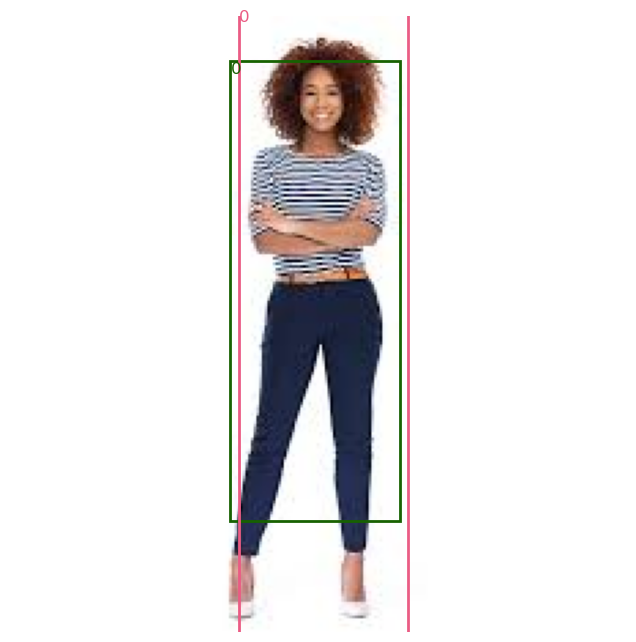

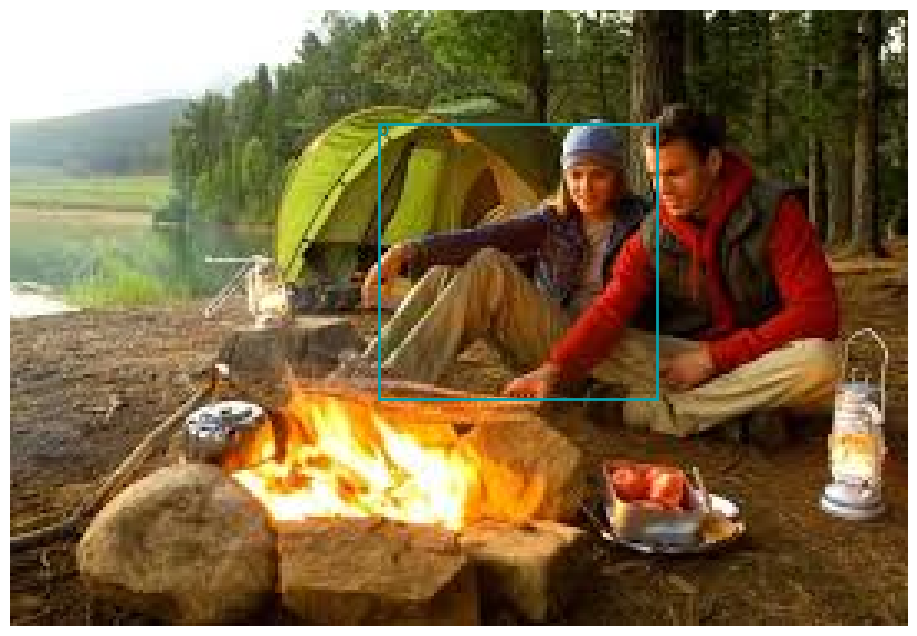

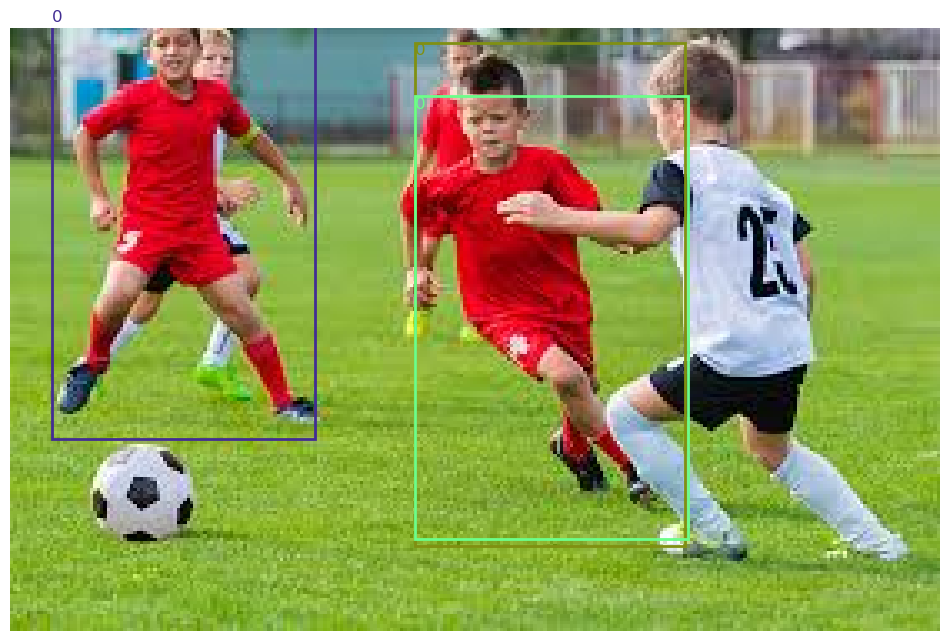

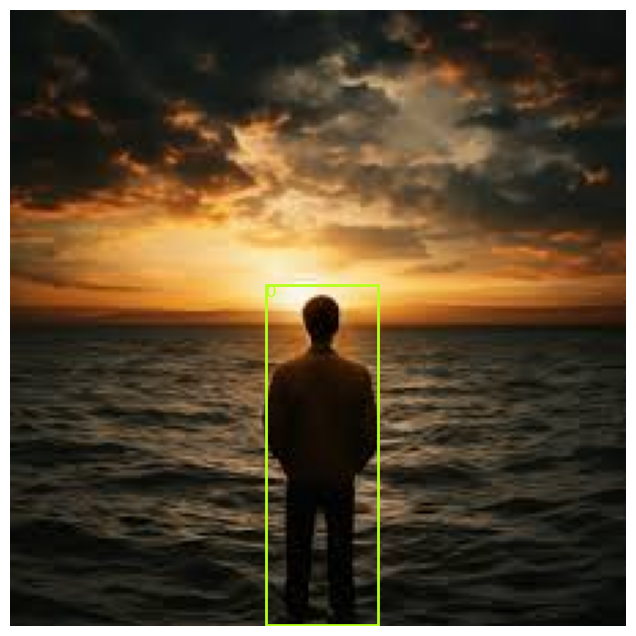

In [20]:
folder_path = './imgs'
process_images_from_folder(folder_path)